# Trabalho Final - Análise de Dados com Python

Integrantes:

    1) Luciano Stegun

### Enunciado
O departamento de crédito da QuantumFinance solicitou a criação de um algoritmo para predizer o valor dos imóveis em determinada região a fim de mensurarem a provisão de crédito para o próximo ano. Assim, baseado no dataset disponível, use Regressão Linear Multivariada para predizer o valor dos imóveis com um RMSE abaixo de 69000. [dataset](https://github.com/ageron/handson-ml2/tree/master/datasets/housing)

In [154]:
import pandas as pd
import numpy as np

### Leitura dos dados
Aqui fazemos o carregamento do arquivo CSV contendo as informações que serão usadas para o treino do modelo

In [155]:
# Leitura dos dados
dataset = pd.read_csv('bases/housing.csv')
dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


### Análise geral do dataset

In [156]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### Tratamento dos dados faltantes
Conforme identificado na etapa anterior existem dados faltantes na coluna "total_bedrooms"
Vamos preencher esses valores faltantes com a média da coluna

In [157]:
mean_total_bedrooms = dataset['total_bedrooms'].mean()
dataset['total_bedrooms'].fillna(mean_total_bedrooms, inplace=True)

### Validação do tratamento de dados faltantes

In [158]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### Verificando tipos das colunas e realizando o Casting

In [159]:
dataset.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [160]:
dataset['housing_median_age'] = dataset['housing_median_age'].astype(int)
dataset['total_rooms'] = dataset['total_rooms'].astype(int)
dataset['total_bedrooms'] = dataset['total_bedrooms'].astype(int)
dataset['population'] = dataset['population'].astype(int)
dataset['households'] = dataset['households'].astype(int)

dataset.dtypes

longitude             float64
latitude              float64
housing_median_age      int64
total_rooms             int64
total_bedrooms          int64
population              int64
households              int64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

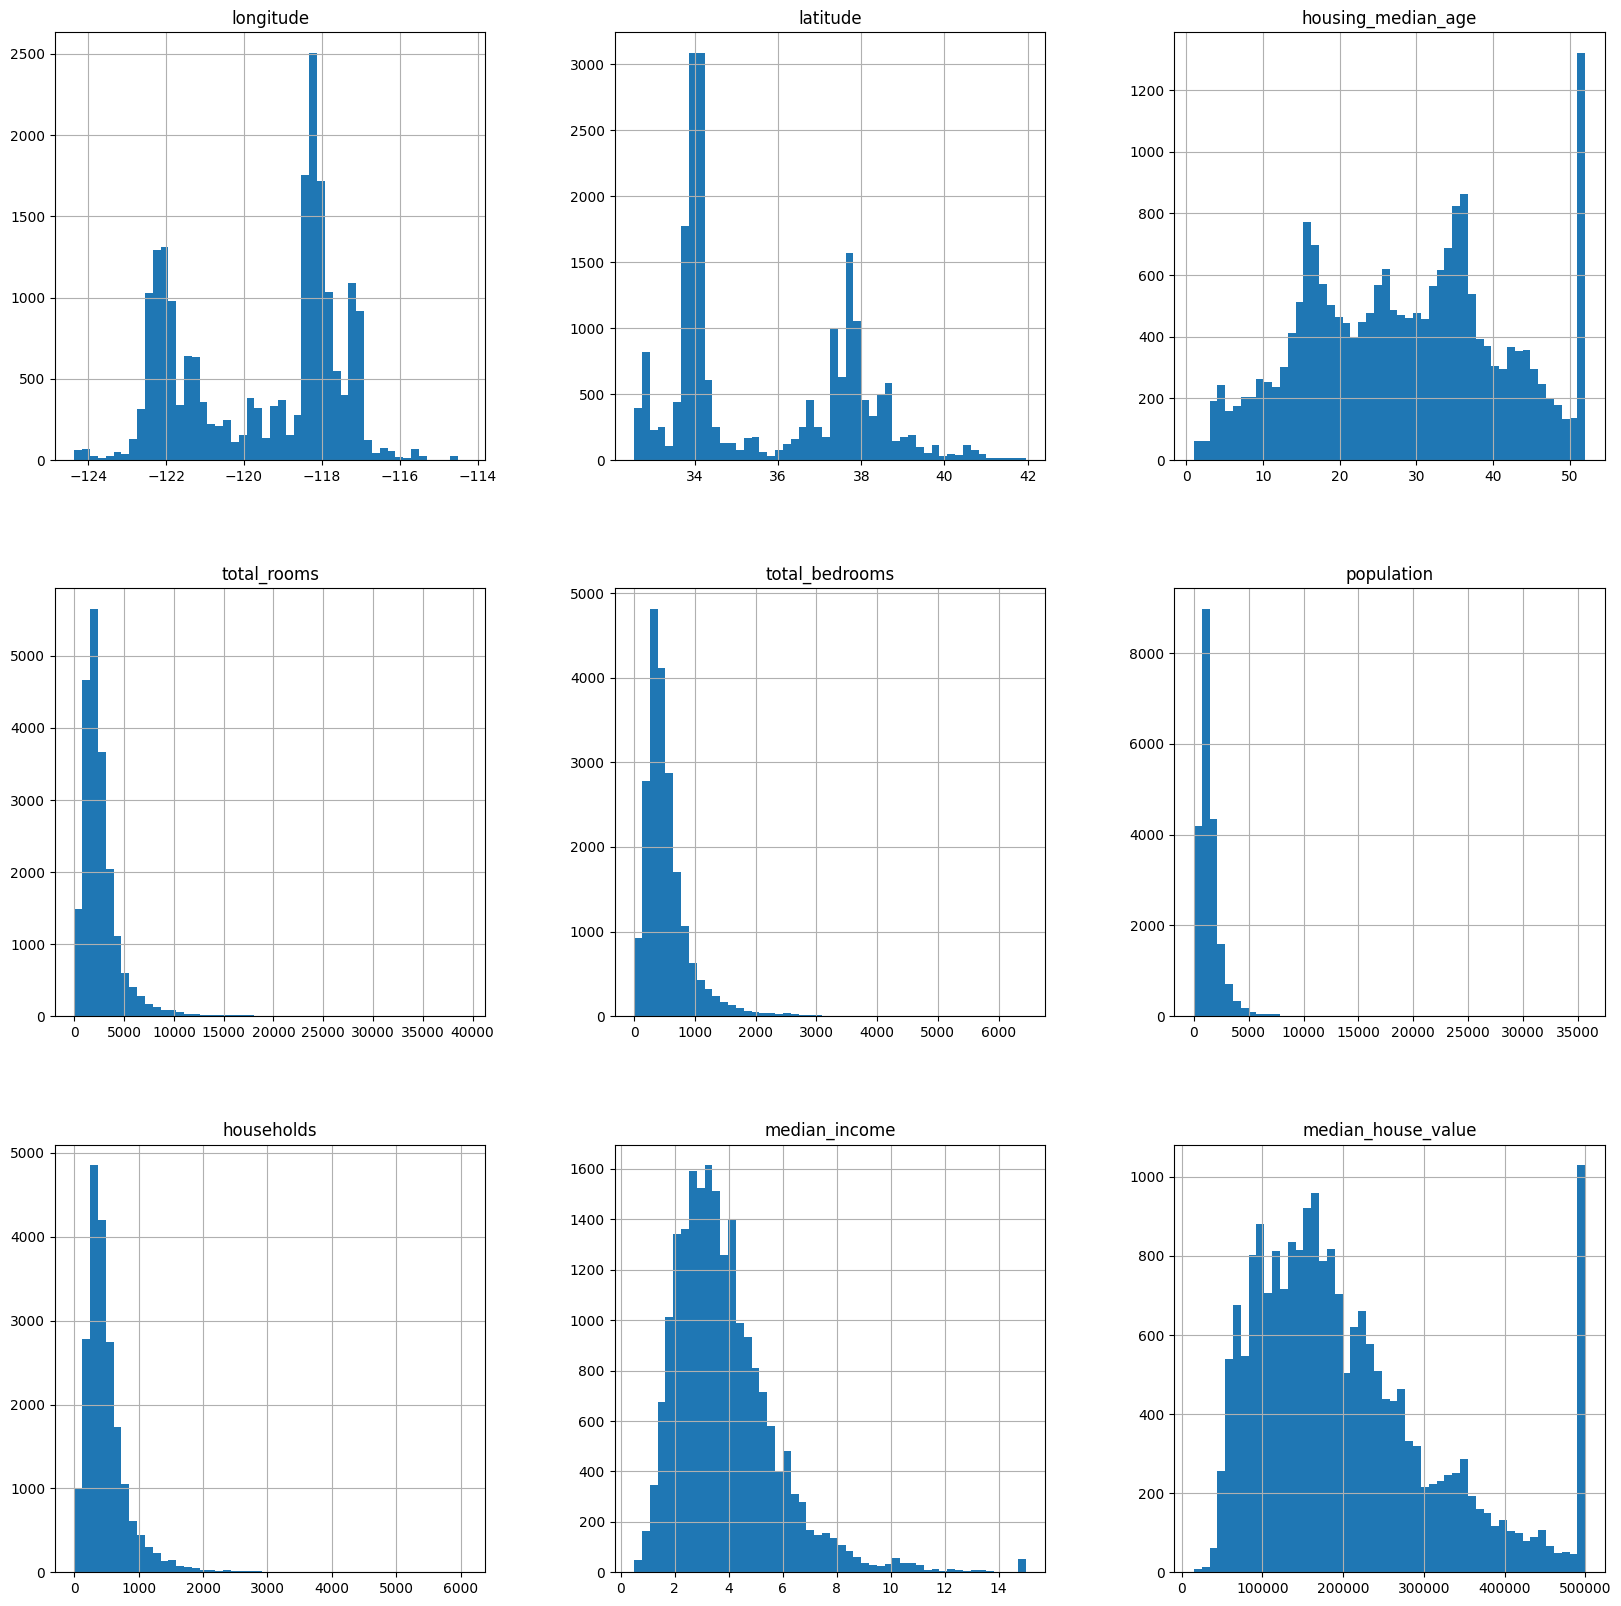

In [161]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogramas
dataset.hist(bins=50, figsize=(20, 20))
plt.show()

### Convertendo as variáveis categóricas
Aqui vamos converter a variável categórica "ocean_proximity" fazendo com que o valor seja mais quanto mais perto da praia a propriedade for

In [162]:
def ocean_proximity_score(ocean_proximity):
    if ocean_proximity == '<1H OCEAN':
        return 1
    elif ocean_proximity == 'NEAR BAY':
        return 2
    elif ocean_proximity == 'INLAND':
        return 3
    elif ocean_proximity == 'NEAR OCEAN':
        return 4
    elif ocean_proximity == 'ISLAND':
        return 5
    else:
        return 0

In [163]:
#dataset['ocean_proximity_score'] = dataset['ocean_proximity'].apply(ocean_proximity_score)
#dataset['ocean_proximity_score'] = dataset['ocean_proximity_score'].astype(int)

In [164]:
dataset_numerical = dataset.copy()
dataset_numerical.drop(['ocean_proximity'], axis=1, inplace=True)

corr = dataset_numerical.corr()
corr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069259,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066657,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.318999,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.927253,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069259,-0.066657,-0.318999,0.927253,1.000000,0.873909,0.974724,-0.007681,0.049454
population,0.099773,-0.108785,-0.296244,0.857126,0.873909,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.974724,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007681,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049454,-0.024650,0.065843,0.688075,1.000000


In [165]:
dataset_numerical = dataset.copy()
dataset_numerical.drop(['ocean_proximity'], axis=1, inplace=True)

corr = dataset_numerical.corr()
corr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069259,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066657,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.318999,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.927253,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069259,-0.066657,-0.318999,0.927253,1.000000,0.873909,0.974724,-0.007681,0.049454
population,0.099773,-0.108785,-0.296244,0.857126,0.873909,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.974724,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007681,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049454,-0.024650,0.065843,0.688075,1.000000


### Análise de correlação
Visualizando graficamente a correlação entre as variáveis

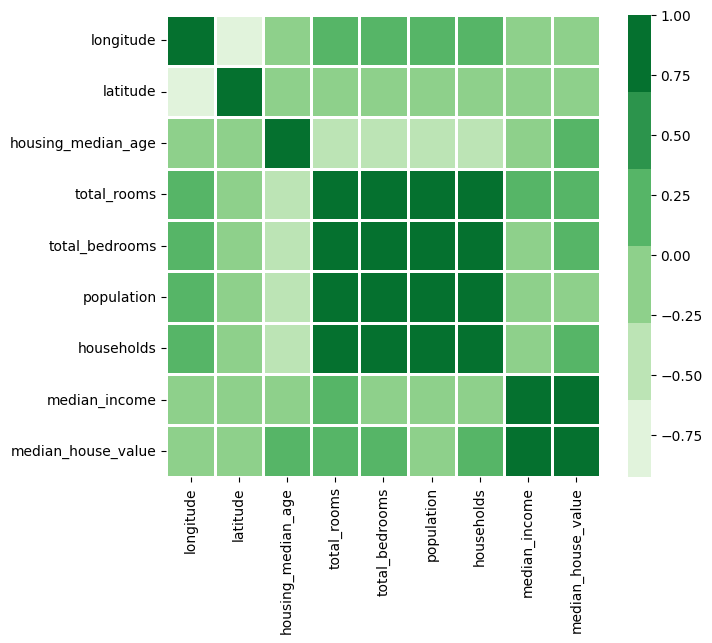

In [166]:
f, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(corr, cmap=sns.color_palette("Greens"), linewidths=1, annot=False);


### Analise da variavel categorica

In [167]:
dataset["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

## Preparação do dataset para o treinamento do modelo

In [168]:
from sklearn.model_selection import train_test_split

X = dataset.drop("median_house_value", axis=1)
y = dataset["median_house_value"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [169]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

num_attribs = list(X.drop("ocean_proximity", axis=1))
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    # ('std_scaler', MinMaxScaler()),
])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
    # ("cat", OrdinalEncoder(), cat_attribs),
])

X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)


## Treinamento do Modelo

In [170]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)

# Fazendo previsões
y_pred = lin_reg.predict(X_test_prepared)


In [171]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Calcular RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

# Calcular MAE
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

# Calcular R²
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")


RMSE: 68832.01946908038
MAE: 50116.69379844961
R²: 0.6390322188262033


In [172]:
comparison_df = pd.DataFrame({
    "Valores Reais": y_test,
    "Valores Preditos": y_pred
})

print(comparison_df.head())

       Valores Reais  Valores Preditos
20046        47700.0           64256.0
3024         45800.0          131072.0
15663       500001.0          261312.0
20484       218600.0          279168.0
9814        278000.0          273920.0


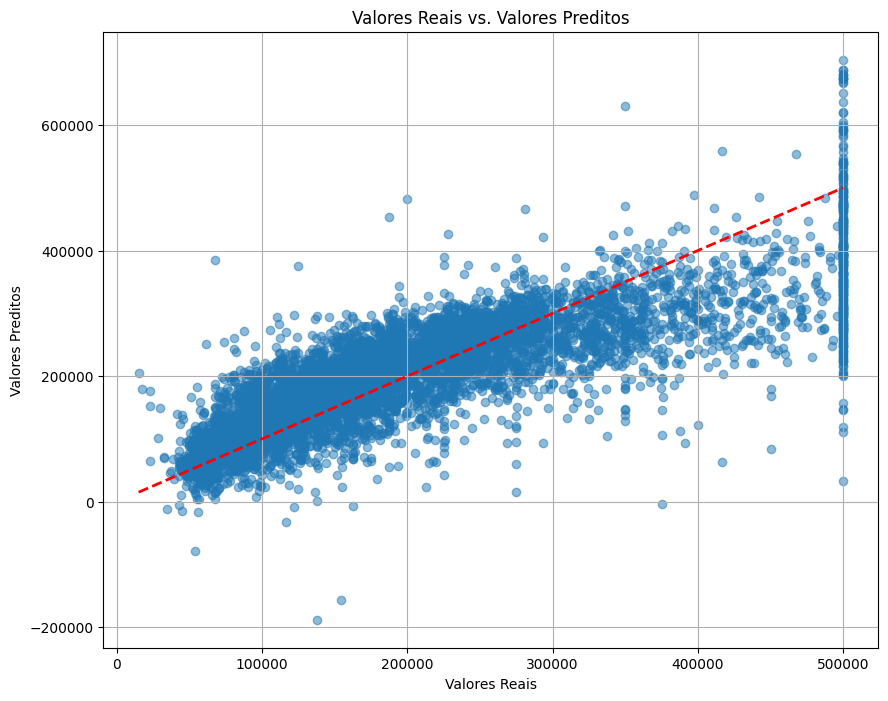

In [173]:
import matplotlib.pyplot as plt

# Plotando os valores reais vs. preditos
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', lw=2, color='red')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Preditos')
plt.title('Valores Reais vs. Valores Preditos')
plt.grid(True)
plt.show()


In [174]:
list_rmse = []
list_mae = []
list_r2 = []


for i in range(0,100):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

    num_attribs = list(X.drop("ocean_proximity", axis=1))
    cat_attribs = ["ocean_proximity"]

    num_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
        # ('std_scaler', MinMaxScaler()),
    ])

    full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
        # ("cat", OrdinalEncoder(), cat_attribs),
    ])

    X_train_prepared = full_pipeline.fit_transform(X_train)
    X_test_prepared = full_pipeline.transform(X_test)

    from sklearn.linear_model import LinearRegression

    lin_reg = LinearRegression()
    lin_reg.fit(X_train_prepared, y_train)

    # Fazendo previsões
    y_pred = lin_reg.predict(X_test_prepared)

    # Calcular RMSE
    list_rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))

    # Calcular MAE
    list_mae.append(mean_absolute_error(y_test, y_pred))

    # Calcular R²
    list_r2.append(r2_score(y_test, y_pred))


In [175]:
np.mean(list_rmse)

68924.63206507341